# VAE for MNIST
In this notebook we try to build a vae for mnist dataset. We will use the following architecture: 2 hidded layer for encoder and decoder, with 256 units each. We will use the reparametrization trick to train the model.

In [2]:
# import data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import mnist from pytorch
import torch
import torchvision
import torchvision.transforms as transforms

# import mnist dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)

# create data loader, just use the number 1 and 9 for now
train_subset = [i for i in range(len(train_dataset)) if train_dataset[i][1] == 1 or train_dataset[i][1] == 9]
test_subset = [i for i in range(len(test_dataset)) if test_dataset[i][1] == 1 or test_dataset[i][1] == 9]

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=False, sampler=torch.utils.data.SubsetRandomSampler(train_subset))
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=100, shuffle=False, sampler=torch.utils.data.SubsetRandomSampler(test_subset))

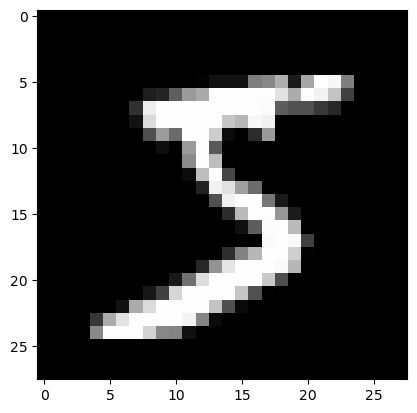

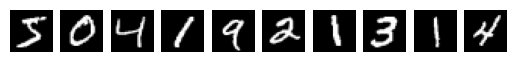

In [6]:
# tshow some images
train_dataset[0][0].shape
plt.imshow(train_dataset[0][0].view(28, 28), cmap='gray')

# show 10 images
fig, ax = plt.subplots(1, 10)
for i in range(10):
    ax[i].imshow(train_dataset[i][0].view(28, 28), cmap='gray')
    ax[i].axis('off')

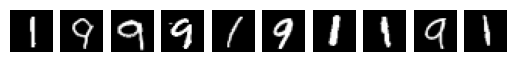

In [7]:
# show 10 images but usign a dataloader
for images, labels in train_loader:
    fig, ax = plt.subplots(1, 10)
    for i in range(10):
        ax[i].imshow(images[i].view(28, 28), cmap='gray')
        ax[i].axis('off')
    break

In [8]:
# define the VAE model
# use 2 hidden layers with 100 units each for both the encoder and decoder

class VAE(torch.nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc1 = torch.nn.Linear(28*28, 100)
        self.fc21 = torch.nn.Linear(100, 2)
        self.fc22 = torch.nn.Linear(100, 2)
        self.fc3 = torch.nn.Linear(2, 100)
        self.fc4 = torch.nn.Linear(100, 28*28)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, log_var = self.encode(x.view(-1, 28*28))
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

In [9]:
# instantiate the model
model = VAE()

# define the loss function
def loss_function(recon_x, x, mu, log_var):
    BCE = torch.nn.functional.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

# define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [10]:
# train the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_idx, (images, _) in enumerate(train_loader):
        recon_images, mu, log_var = model(images)
        loss = loss_function(recon_images, images, mu, log_var)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, train_loss))

Epoch [1/10], Loss: 2586698.7676
Epoch [2/10], Loss: 1524270.2959
Epoch [3/10], Loss: 1400281.4258
Epoch [4/10], Loss: 1344595.9258
Epoch [5/10], Loss: 1311926.5312
Epoch [6/10], Loss: 1289083.1094
Epoch [7/10], Loss: 1273491.3789
Epoch [8/10], Loss: 1259640.5723
Epoch [9/10], Loss: 1248971.4512
Epoch [10/10], Loss: 1239176.9326


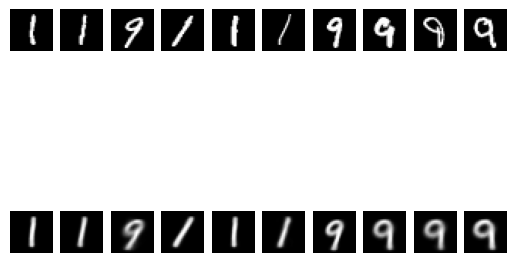

In [34]:
# test the model, for 10 images from the test set show original and reconstructed images
for images, _ in test_loader:
    recon_images, _, _ = model(images)
    fig, ax = plt.subplots(2, 10)
    for i in range(10):
        ax[0][i].imshow(images[i].view(28, 28), cmap='gray')
        ax[0][i].axis('off')
        ax[1][i].imshow(recon_images[i].view(28, 28).detach().numpy(), cmap='gray')
        ax[1][i].axis('off')
    break

In [46]:
# plot the latent space of the train set

model.eval()
latent_vectors = []
categories = [] 

for images, labels in train_loader:
    _, mu, _ = model(images)
    latent_vectors.append(mu.detach().numpy())
    categories.append(labels.detach().numpy())

latent_vectors = np.concatenate(latent_vectors, axis=0)
categories = np.concatenate(categories, axis=0)

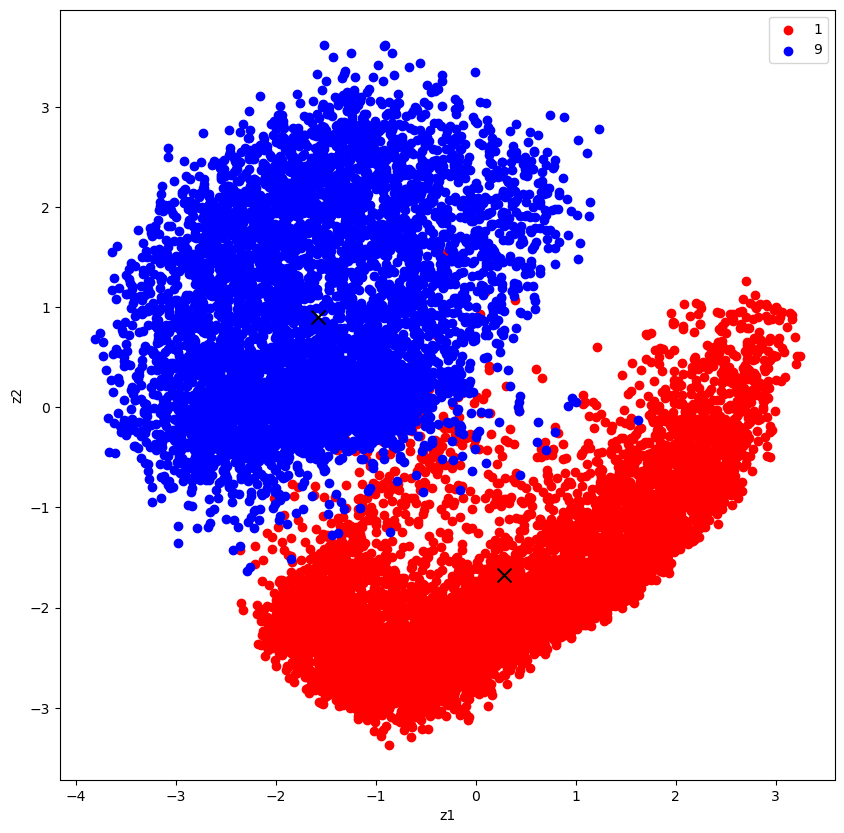

In [50]:
plt.figure(figsize=(10, 10))
plt.scatter(latent_vectors[categories==1, 0], latent_vectors[categories==1, 1], label='1', color='red')
plt.scatter(latent_vectors[categories==9, 0], latent_vectors[categories==9, 1], label='9', color='blue')

# get the mean on 1 and 9
mean_1 = np.mean(latent_vectors[categories==1], axis=0)
mean_9 = np.mean(latent_vectors[categories==9], axis=0)

plt.scatter(mean_1[0], mean_1[1], color='black', marker='x', s=100)
plt.scatter(mean_9[0], mean_9[1], color='black', marker='x', s=100)

# add labels
plt.xlabel('z1')
plt.ylabel('z2')

# add legend
plt.legend()


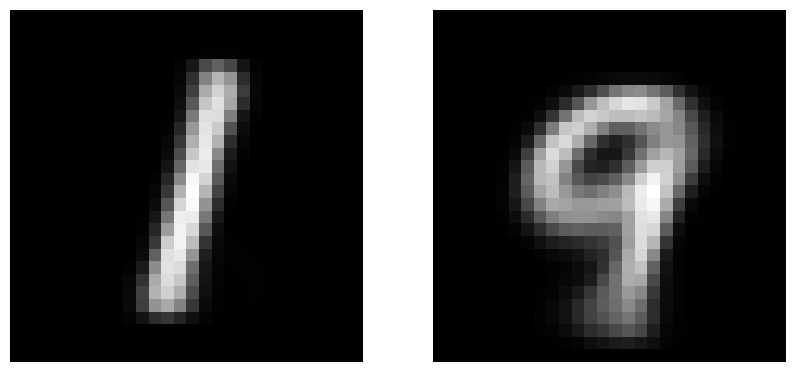

In [48]:
# show the recostruction from the mean
plt.figure(figsize=(10, 10))
for i, mu in enumerate([mean_1, mean_9]):
    z = torch.tensor(mu).float()
    recon_image = model.decode(z)
    plt.subplot(1, 2, i+1)
    plt.imshow(recon_image.view(28, 28).detach().numpy(), cmap='gray')
    plt.axis('off')

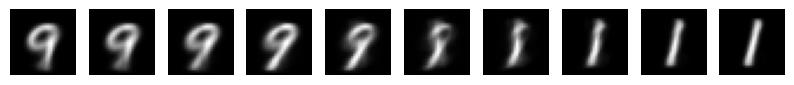

In [49]:
# generate 10 images from the line connecting the means
plt.figure(figsize=(10, 10))
for i, alpha in enumerate(np.linspace(0, 1, 10)):
    z = alpha*mean_1 + (1-alpha)*mean_9
    z = torch.tensor(z).float()
    recon_image = model.decode(z)
    plt.subplot(1, 10, i+1)
    plt.imshow(recon_image.view(28, 28).detach().numpy(), cmap='gray')
    plt.axis('off')